# Analysis of the Cell Selectivity for DRD87 in EPM, NO, OFT, & POPP

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
from analysis import sig_proc
import warnings

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == labels[0]])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[1]]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[2]]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[3]]))

    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

In [4]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


## Import the csv of raw neuron signal data (collected during EPM experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [5]:
DRD87_EPM_DATA = pd.read_csv(raw_files[7], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_EPM_DATA, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

DRD87_EPM_behavior_df = pd.read_csv(raw_files[8], header=None)
drd87_epm_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_EPM_behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:29: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



## We compute the actual $\hat{D}$ values for all of the neuron column vectors in DRD87's `neuron_concated_behavior` dataframe

In [6]:
epm_real_diff_vals = drd87_epm_fe.set_real_diff_df(drd87_epm_fe.neuron_concated_behavior, drd87_epm_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
epm_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:109: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69,neuron70
D,5.72857,-3.00185,-1.36973,12.1606,-0.555661,-3.64355,8.0656,-3.7702,-0.683886,-3.68069,...,3.74837,-0.92522,0.176564,0.569157,-1.74818,0.711728,1.67555,1.55181,1.89085,4.47428


## Now, we construct the permutation distributions of the $\hat{D}$ values, for each neuron column vector, from its values in a large number of resamples.
#### Note: use $1000$ resamples for preliminary analysis, and $\ge 10000$ for presentation/publication.

In [7]:
epm_resampled_df = Resampler.shuffle(10000, drd87_epm_fe.neuron_concated_behavior, drd87_epm_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")

## Next, we plot all the distribution of each neuron, after permutation resampling.

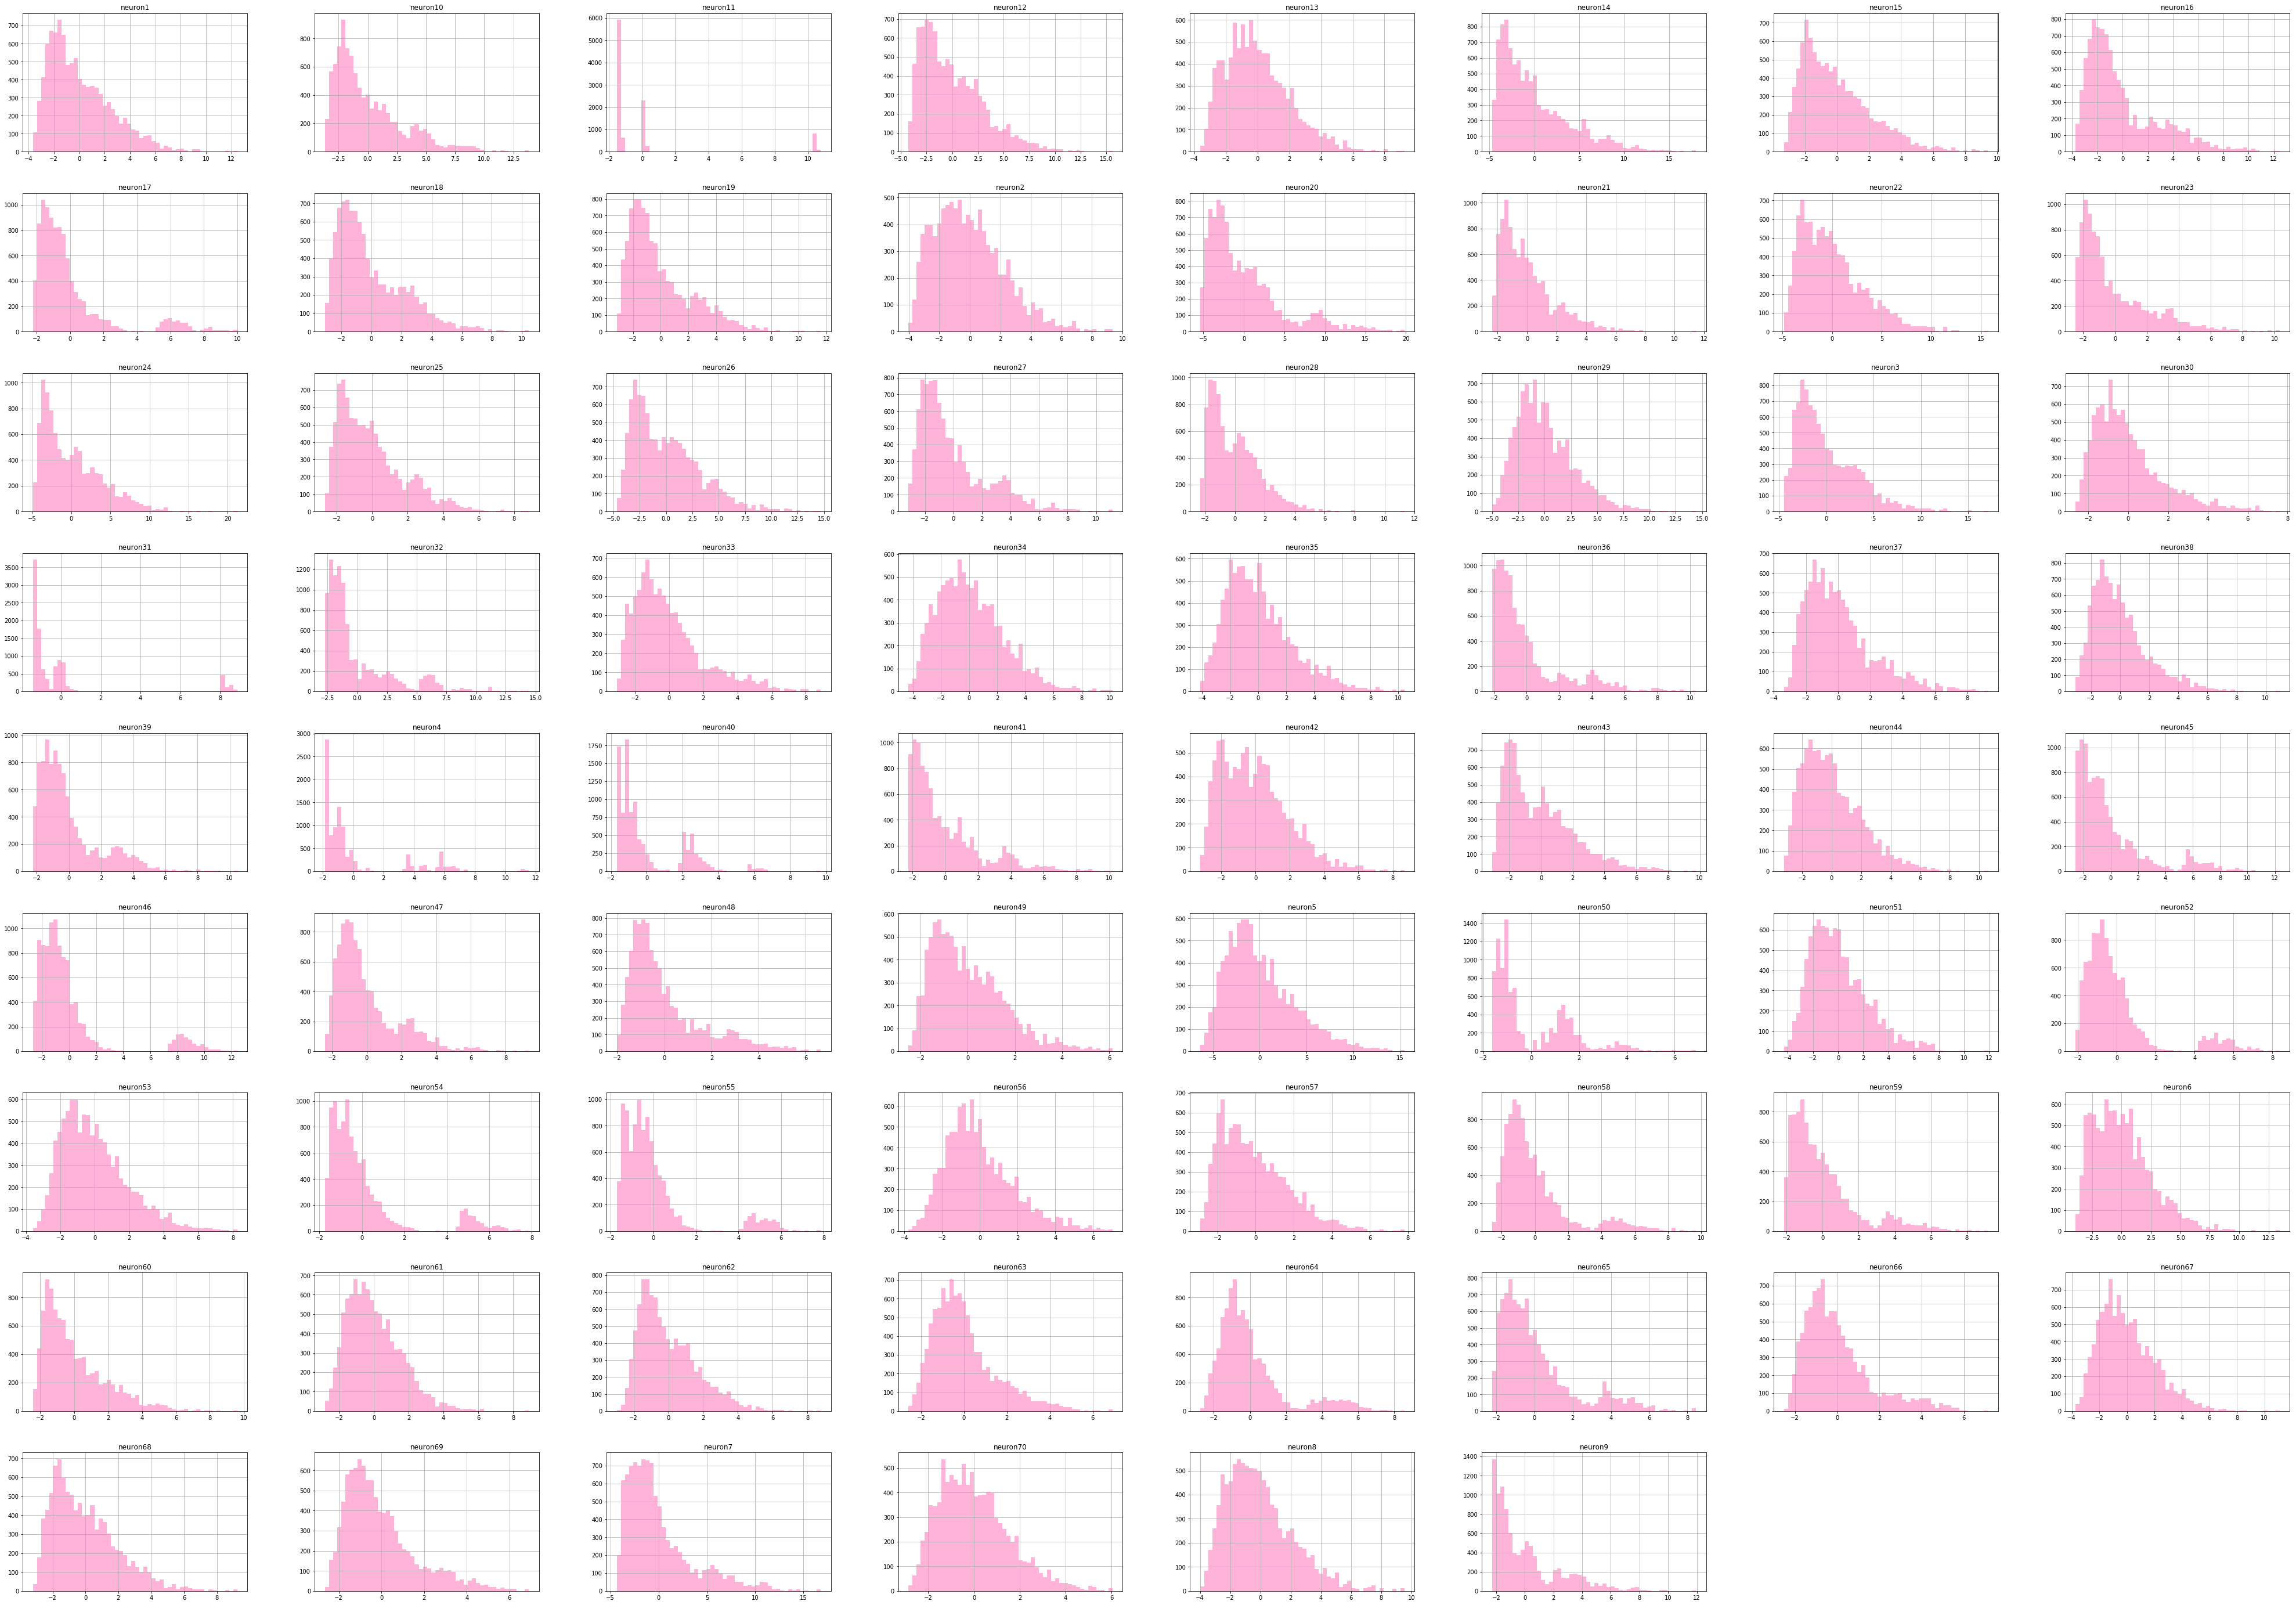

In [8]:
epm_resampled_df.hist(alpha=0.5, color='hotpink', bins=50, figsize=(70, 50));

## Now, we actually conduct the **permuation test**, where we classify neurons as either *selective* or *not-selective*

In [9]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_epm_fe.auc_df, epm_resampled_df, epm_real_diff_vals, p_value=0.05, threshold=5)

## After classifying the neurons as either selective, not-selective, or unclassified, we perform a "deeper classification". Namely, we go through and classify each *selective* neuron with a $\hat{D} > 0$ as selective for `OpenArms_centerpoint`. Likewise, we go through and classify each *selective* neuron with a $\hat{D} < 0$ as selective for `ClosedArms_centerpoint`.

In [10]:
epm_selective_neurons = Resampler.classify_by_behavior(drd87_classified_neurons, epm_real_diff_vals, "OpenArms_centerpoint", "ClosedArms_centerpoint")
plot_pie_chart(epm_selective_neurons, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## Import the csv of raw neuron signal data (collected during POPP experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [11]:
DRD87_POPP_DATA = pd.read_csv(raw_files[3], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_POPP_DATA, 2, 0.5, 0.2, 10)

DRD87_POPP_behavior_df = pd.read_csv(raw_files[1])
DRD87_POPP_behavior_df.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
DRD87_POPP_behavior_df.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Odor_centerpoint", "Neutral_centerpoint", "Odor_Cup_centerpoint", "Neutral_Cup_centerpoint"]

drd87_popp_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_POPP_behavior_df, row_multiple=2)

In [12]:
popp_real_diff_vals = drd87_popp_fe.set_real_diff_df(drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")
popp_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:109: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron66,neuron67,neuron68,neuron69,neuron70,neuron71,neuron72,neuron73,neuron74,neuron75
D,1.92008,4.25264,-3.09435,0.676467,7.49938,-2.32122,4.86393,-2.69076,3.83389,5.27693,...,1.56782,2.88715,2.84779,-0.912353,0.786862,-0.342486,1.66577,4.07939,2.27167,0.907633


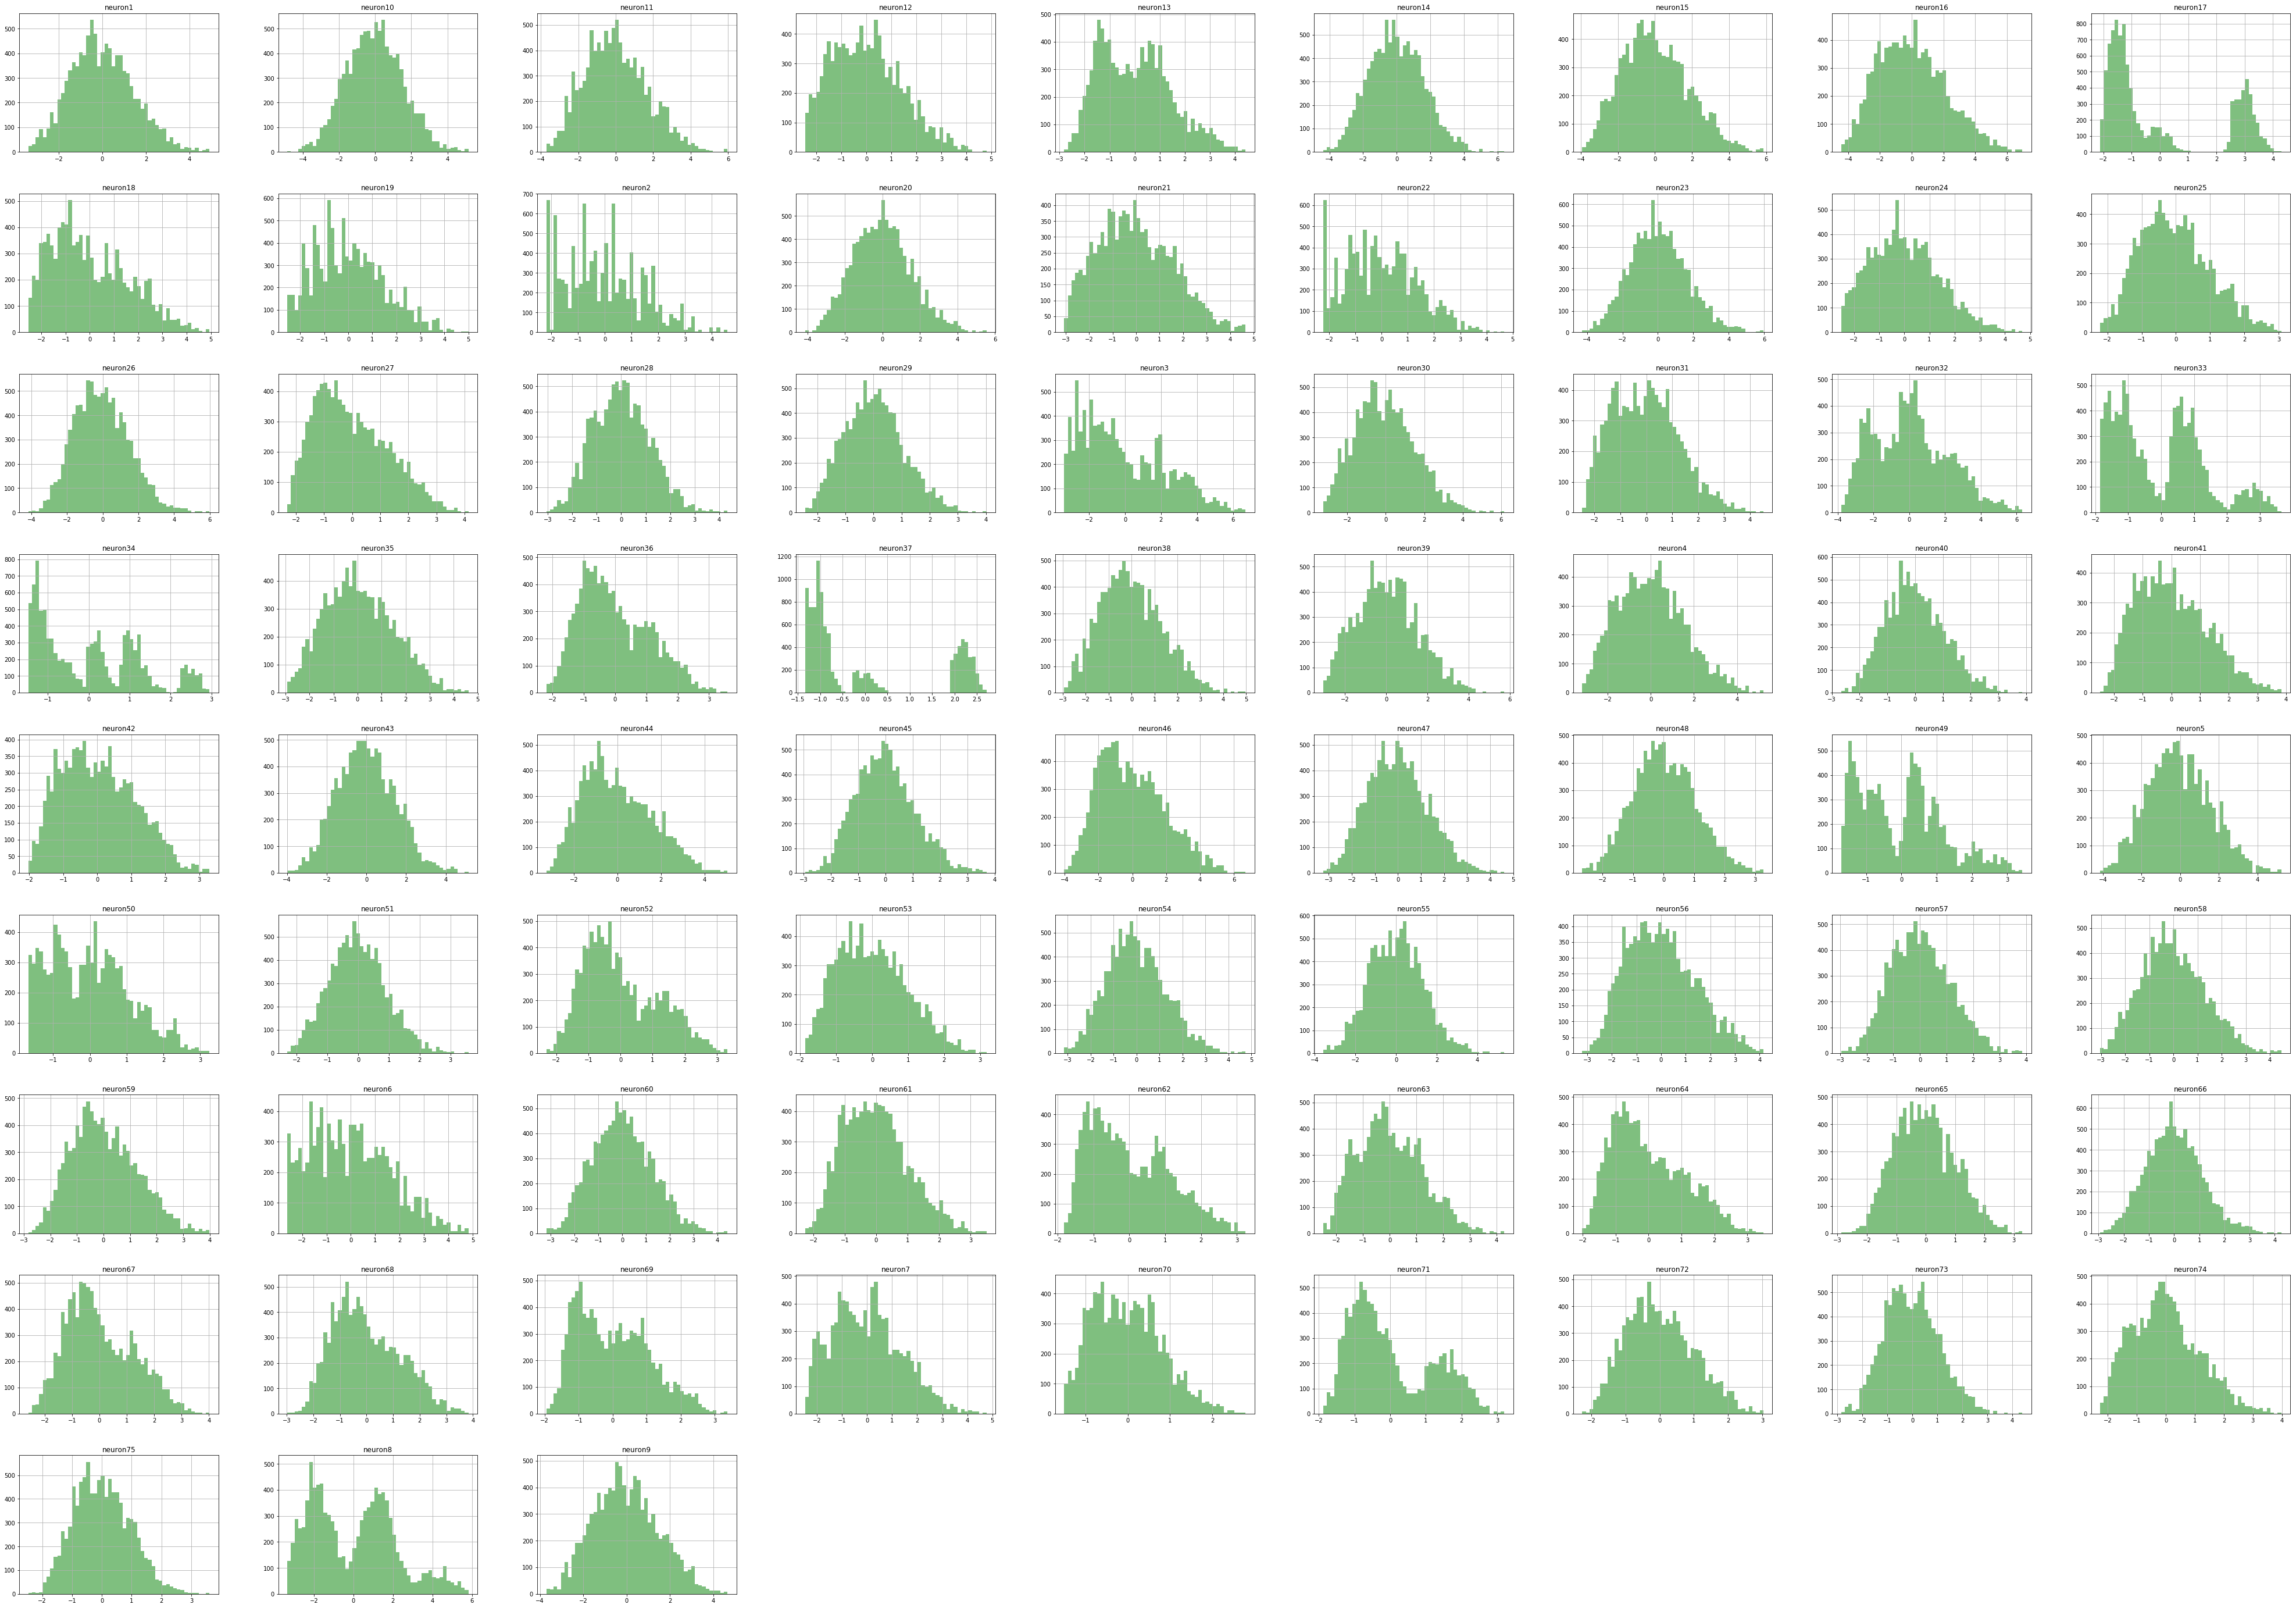

In [13]:
popp_resampled_df = Resampler.shuffle(10000, drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")
popp_resampled_df.hist(alpha=0.5, color='green', bins=50, figsize=(70, 50));

In [14]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_popp_fe.auc_df, popp_resampled_df, popp_real_diff_vals, p_value=0.05, threshold=5)

In [15]:
popp_selective_neurons = Resampler.classify_by_behavior(drd87_classified_neurons, popp_real_diff_vals, "Odor_centerpoint", "Neutral_centerpoint")
plot_pie_chart(popp_selective_neurons, "Odor_centerpoint", "Neutral_centerpoint", "not-selective", "unclassified")